# 학습 알고리즘 구현
- 미니배치
- 신경망 학습
- 학습 데이터 평가
----

## 필요 라이브러리, 데이터셋 import

In [179]:
import numpy as np
import matplotlib.pylab as plt
import sys, os
sys.path.append(os.pardir)

from dataset.mnist import load_mnist

## 사용 함수
- 소프트맥스 (크기에 맞게 변경)
- 시그모이드
- 기울기 계산


In [180]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

In [181]:
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

In [182]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
    
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    
    return grad

In [183]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [184]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## 학습에 사용될 클래스

In [185]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

## 미니배치 학습

In [186]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [187]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [188]:
iters_num = 10000  
train_size = x_train.shape[0]
print(train_size)
batch_size = 100   
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

60000


In [189]:
iter_per_epoch = max(train_size / batch_size, 1)

In [190]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.0993, 0.1032
train acc, test acc | 0.7876, 0.7927
train acc, test acc | 0.87545, 0.8767
train acc, test acc | 0.8991833333333333, 0.9001
train acc, test acc | 0.9070666666666667, 0.9098
train acc, test acc | 0.9140666666666667, 0.9149
train acc, test acc | 0.9191, 0.9229
train acc, test acc | 0.9226666666666666, 0.923
train acc, test acc | 0.9268, 0.9281
train acc, test acc | 0.9304333333333333, 0.9309
train acc, test acc | 0.93365, 0.9339
train acc, test acc | 0.936, 0.9347
train acc, test acc | 0.9382166666666667, 0.9368
train acc, test acc | 0.9409666666666666, 0.9397
train acc, test acc | 0.9429833333333333, 0.9413
train acc, test acc | 0.9447833333333333, 0.9445
train acc, test acc | 0.9468, 0.945


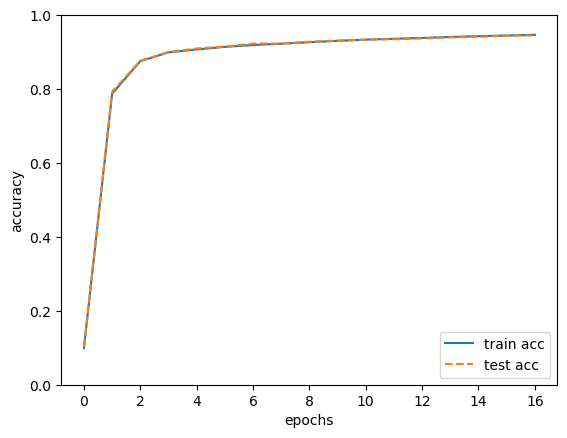

In [191]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
